In [160]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm
import torch

import warnings
warnings.filterwarnings('ignore')

## Зачем
- Посмотрим, как проводится операция свертки, pooling и flatten;    
- Попробуем собрать сверточную нейронную сеть на PyTorch

## Цветовые каналы

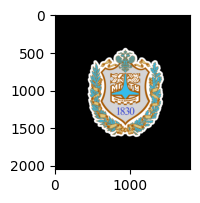

In [2]:
image = cv2.imread('./image.png')
plt.figure(figsize=(2,2))
plt.imshow(image);

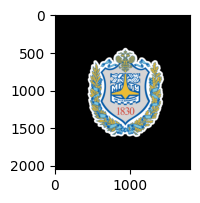

In [3]:
image_ex = image[...,::-1]
plt.figure(figsize=(2,2))
plt.imshow(image_ex)

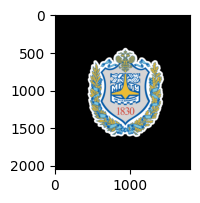

In [4]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(2,2))
plt.imshow(image_rgb);

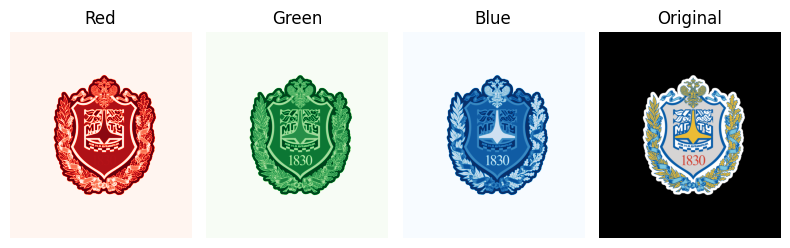

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

img_mat = np.array(image_rgb)

fig, axs = plt.subplots(1, 4, figsize=(8, 8))

axs[0].imshow(img_mat[:, :, 0], cmap=cm.Reds)
axs[0].set_title('Red')
axs[0].axis('off')

axs[1].imshow(img_mat[:, :, 1], cmap=cm.Greens)
axs[1].set_title('Green')
axs[1].axis('off')

axs[2].imshow(img_mat[:, :, 2], cmap=cm.Blues)
axs[2].set_title('Blue')
axs[2].axis('off')

axs[3].imshow(img_mat[:, :, :])
axs[3].set_title('Original')
axs[3].axis('off')

plt.tight_layout()
plt.show()


## Операция свертки 

- Количество входных каналов in_channels
- Количество выходных каналов out_channels
- Размер ядра kernel_size
- Шаг stride
- Паддинг padding
- Режим паддинга padding_mode ('zeros', 'reflect', ...)

In [6]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

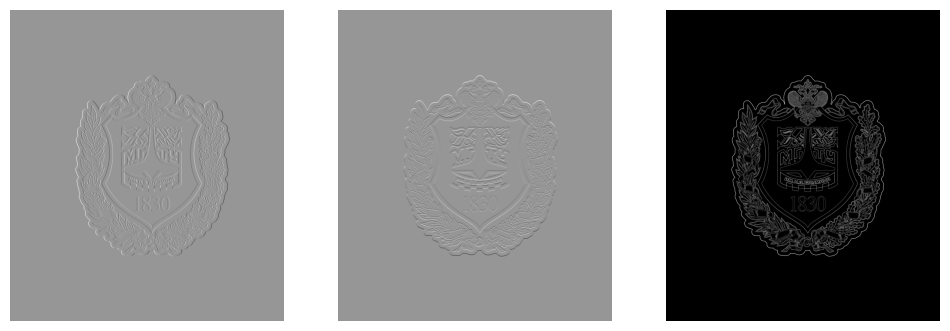

In [7]:
from scipy.signal import convolve2d

G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
res_y = convolve2d(bw_image, G_y, "same")
res_sobel = (res_x**2 + res_y**2)**0.5



fig, axs = plt.subplots(1, 3, figsize=(12, 12))

axs[0].imshow(res_x, cmap=plt.cm.Greys_r)
axs[0].axis('off')

axs[1].imshow(res_y, cmap=plt.cm.Greys_r)
axs[1].axis('off')

axs[2].imshow(res_sobel)
axs[2].axis('off')

plt.imshow(res_sobel, cmap=plt.cm.Greys_r);

## Операция свертки с нуля (conv2d)

In [8]:
from PIL import Image, ImageOps

In [9]:
img = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

In [10]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray')
    

def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img2, cmap='gray')
    ax[1].axis('off')

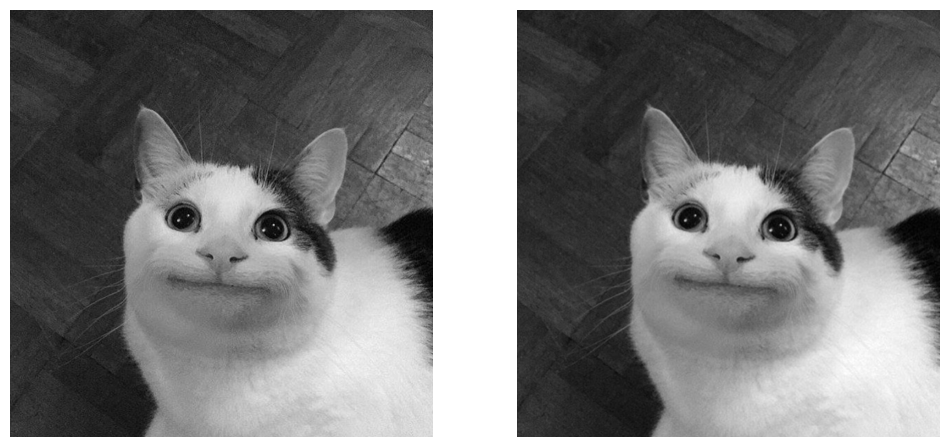

In [11]:
import numpy as np

def calculate_target_size(img_size: int, kernel_size: int, stride=1) -> int:
    """Размер выходной матрицы после применения свёртки"""
    
    return (img_size - kernel_size) // stride + 1


def convolve(img: np.array, kernel: np.array) -> np.array:
    # Размеры изображения и ядра
    img_h, img_w = img.shape
    kernel_h, kernel_w = kernel.shape
    
    # Вычисляем целевые размеры для свёртки
    tgt_h = calculate_target_size(img_h, kernel_h)
    tgt_w = calculate_target_size(img_w, kernel_w)
    
    # Массив для хранения результата свёртки
    convolved_img = np.zeros((tgt_h, tgt_w))
    
    # Проходим по строкам изображения
    for i in range(tgt_h):
        # Проходим по столбцам изображения
        for j in range(tgt_w):
            # Извлекаем подматрицу изображения, соответствующую размеру ядра
            mat = img[i:i+kernel_h, j:j+kernel_w]
            
            # Применяем свёртку: поэлементное умножение и суммирование
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img


sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])


img_with_kernel = convolve(img=img, kernel=blur)
plot_two_images(
    img1=img, 
    img2=img_with_kernel
)

# Max pooling

In [21]:
import numpy as np
from numpy.lib.stride_tricks import as_strided


def pool2d(A, kernel_size, stride, padding=0, pool_mode='max'):

    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size) // stride + 1,
                    (A.shape[1] - kernel_size) // stride + 1)
    
    shape_w = (output_shape[0], output_shape[1], kernel_size, kernel_size)
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])
    
    A_w = as_strided(A, shape_w, strides_w)

    # Return the result of pooling
    return A_w.max(axis=(2, 3))
    

A = np.array([[1, 1, 2, 4],
              [5, 6, 7, 8],
              [3, 2, 1, 0],
              [1, 2, 3, 4]])

pool2d(A, kernel_size=2, stride=2, padding=0, pool_mode='max')

array([[6, 8],
       [3, 4]])

## Flatten

In [4]:
from IPython.display import Video

Video("flatten.mp4", width=920, height=920)

#### В PyTorch

In [2]:
t = torch.tensor([[[1, 2],
                   [3, 4]],
                  [[5, 6],
                   [7, 8]]])

In [3]:
torch.flatten(t)

tensor([1, 2, 3, 4, 5, 6, 7, 8])

In [4]:
torch.flatten(t, start_dim=1)

tensor([[1, 2, 3, 4],
        [5, 6, 7, 8]])

#### В Numpy

In [ ]:
t2 = np.array([[[1,2], [3,4]], [[5,6], [7,8]]])
t2.flatten()

## Сверточная нейронная сеть для бинарной классификации

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

### Подгрузка данных

In [70]:
class CustomImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = ['indoor', 'outdoor']  # Указываем только нужные классы
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.imgs = self.make_dataset()

    def make_dataset(self):
        instances = []
        for target_class in self.classes:
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(self.root, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in sorted(fnames):
                    if fname.startswith('._'):  # Игнорируем скрытые файлы
                        continue
                    path = os.path.join(root, fname)
                    if not path.endswith('.ipynb_checkpoints'):  # Игнорируем папку .ipynb_checkpoints
                        item = (path, class_index)
                        instances.append(item)
        return instances

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

data_dir = './PetImages/'

# Определяем трансформации
transform = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])  
])

# Создаем экземпляр нашего кастомного датасета
full_data = CustomImageFolder(data_dir, transform=transform)

In [161]:
print("Классы и их индексы:")
for class_name, class_idx in full_data.class_to_idx.items():
    print(f"Класс: {class_name}, Индекс: {class_idx}")

Классы и их индексы:
Класс: indoor, Индекс: 0
Класс: outdoor, Индекс: 1


In [72]:
#почему то не работает (((
data_dir = './PetImages/'

transform = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])  
])

full_data = ImageFolder(data_dir, transform=transform)#


FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [73]:

train_size = int(0.8 * len(full_data))
val_size = int(0.1 * len(full_data))
test_size = len(full_data) - train_size - val_size

train_data, val_data, test_data = random_split(full_data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [74]:
# Для логирования в Tensorboard
writer = SummaryWriter('runs/cats_vs_dogs_experiment_1')

In [75]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [76]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Первый блок: Conv -> BatchNorm -> ReLU -> MaxPool
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Второй блок: Conv -> BatchNorm -> ReLU -> MaxPool
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Третий блок: Conv -> BatchNorm -> ReLU -> MaxPool
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Четвёртый блок: Conv -> BatchNorm -> ReLU -> MaxPool
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Полносвязные слои
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)  
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x if self.fc_layers[-1].out_features > 1 else torch.sigmoid(x)

In [77]:
model = ImprovedCNN()

model = nn.DataParallel(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


DataParallel(
  (module): ImprovedCNN(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(256, ep

In [78]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Сохранение состояния модели"""
    torch.save(state, filename)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        

        if val_acc > best_val_acc:
            print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
            best_val_acc = val_acc
            
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_acc
            }
            save_checkpoint(checkpoint, 'cnn_best_checkpoint.pth')
            
    
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy


In [80]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 52.4633, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756
Validation accuracy improved from 0.0000 to 0.4756. Saving model...


 20%|██        | 2/10 [29:46<1:59:16, 894.53s/it]

Epoch [2/10], Loss: 52.4645, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


 30%|███       | 3/10 [44:42<1:44:24, 894.87s/it]

Epoch [3/10], Loss: 52.4645, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


 40%|████      | 4/10 [59:27<1:29:06, 891.00s/it]

Epoch [4/10], Loss: 52.4675, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


 50%|█████     | 5/10 [1:14:12<1:14:05, 889.00s/it]

Epoch [5/10], Loss: 52.4616, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


 60%|██████    | 6/10 [1:29:01<59:15, 888.90s/it]  

Epoch [6/10], Loss: 52.4675, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


 70%|███████   | 7/10 [1:43:48<44:24, 888.30s/it]

Epoch [7/10], Loss: 52.4645, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


 80%|████████  | 8/10 [1:58:41<29:39, 889.79s/it]

Epoch [8/10], Loss: 52.4675, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


 90%|█████████ | 9/10 [2:13:32<14:50, 890.33s/it]

Epoch [9/10], Loss: 52.4704, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


100%|██████████| 10/10 [2:28:37<00:00, 891.70s/it]

Epoch [10/10], Loss: 52.4645, Accuracy: 0.4753, Val Loss: 52.4413, Val Accuracy: 0.4756


In [162]:
!tensorboard --logdir=runs

Traceback (most recent call last):
  File "/raid/alebedev/anaconda3/bin/tensorboard", line 7, in <module>
    from tensorboard.main import run_main
  File "/raid/alebedev/anaconda3/lib/python3.7/site-packages/tensorboard/main.py", line 40, in <module>
    from tensorboard import default
  File "/raid/alebedev/anaconda3/lib/python3.7/site-packages/tensorboard/default.py", line 38, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/raid/alebedev/anaconda3/lib/python3.7/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 30, in <module>
    from tensorboard.util import tensor_util
  File "/raid/alebedev/anaconda3/lib/python3.7/site-packages/tensorboard/util/tensor_util.py", line 24, in <module>
    from tensorboard.compat.tensorflow_stub import dtypes, compat, tensor_shape
  File "/raid/alebedev/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/__init__.py", line 25, in <module>
    from .dtypes import as_dtype  # noqa
  File "/ra

![title](img/tensorboard_res.png)

## Инференс

In [35]:
def load_checkpoint(filename='checkpoint.pth'):
    
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict']) 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
    epoch = checkpoint['epoch'] 
    loss = checkpoint['loss'] 
    accuracy = checkpoint['accuracy']  
    print(f"Checkpoint loaded. Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")
    return epoch, loss, accuracy

model = ImprovedCNN().to(device)  
optimizer = optim.Adam(model.parameters(), lr=0.001)  

epoch, loss, accuracy = load_checkpoint('cnn_best_checkpoint.pth')

model.eval()


RuntimeError: Error(s) in loading state_dict for ImprovedCNN:
	Missing key(s) in state_dict: "conv_layers.0.weight", "conv_layers.0.bias", "conv_layers.1.weight", "conv_layers.1.bias", "conv_layers.1.running_mean", "conv_layers.1.running_var", "conv_layers.4.weight", "conv_layers.4.bias", "conv_layers.5.weight", "conv_layers.5.bias", "conv_layers.5.running_mean", "conv_layers.5.running_var", "conv_layers.8.weight", "conv_layers.8.bias", "conv_layers.9.weight", "conv_layers.9.bias", "conv_layers.9.running_mean", "conv_layers.9.running_var", "conv_layers.12.weight", "conv_layers.12.bias", "conv_layers.13.weight", "conv_layers.13.bias", "conv_layers.13.running_mean", "conv_layers.13.running_var", "fc_layers.0.weight", "fc_layers.0.bias", "fc_layers.3.weight", "fc_layers.3.bias". 
	Unexpected key(s) in state_dict: "module.conv_layers.0.weight", "module.conv_layers.0.bias", "module.conv_layers.1.weight", "module.conv_layers.1.bias", "module.conv_layers.1.running_mean", "module.conv_layers.1.running_var", "module.conv_layers.1.num_batches_tracked", "module.conv_layers.4.weight", "module.conv_layers.4.bias", "module.conv_layers.5.weight", "module.conv_layers.5.bias", "module.conv_layers.5.running_mean", "module.conv_layers.5.running_var", "module.conv_layers.5.num_batches_tracked", "module.conv_layers.8.weight", "module.conv_layers.8.bias", "module.conv_layers.9.weight", "module.conv_layers.9.bias", "module.conv_layers.9.running_mean", "module.conv_layers.9.running_var", "module.conv_layers.9.num_batches_tracked", "module.conv_layers.12.weight", "module.conv_layers.12.bias", "module.conv_layers.13.weight", "module.conv_layers.13.bias", "module.conv_layers.13.running_mean", "module.conv_layers.13.running_var", "module.conv_layers.13.num_batches_tracked", "module.fc_layers.0.weight", "module.fc_layers.0.bias", "module.fc_layers.3.weight", "module.fc_layers.3.bias". 

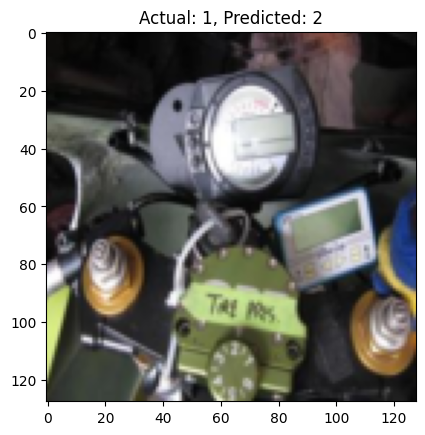

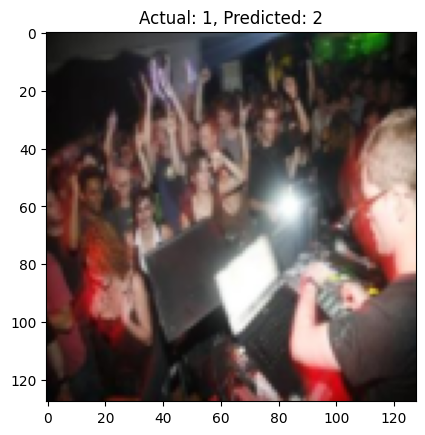

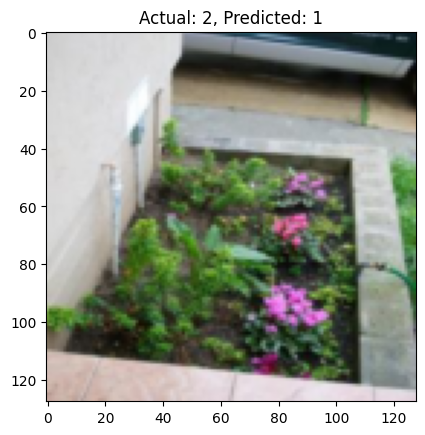

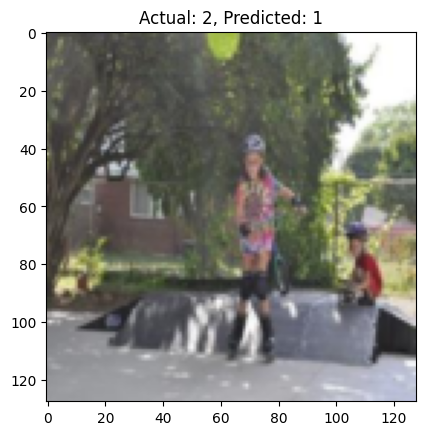

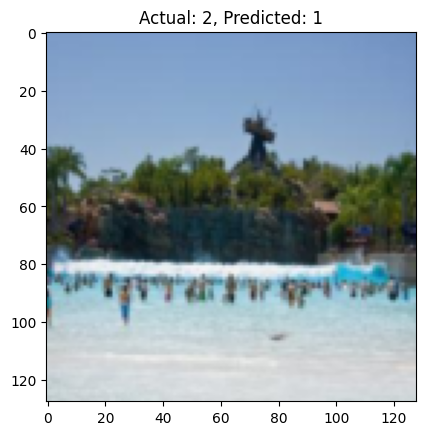

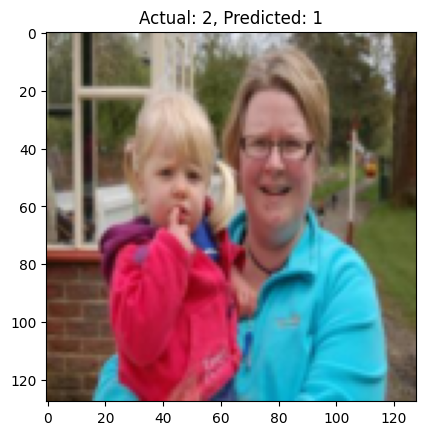

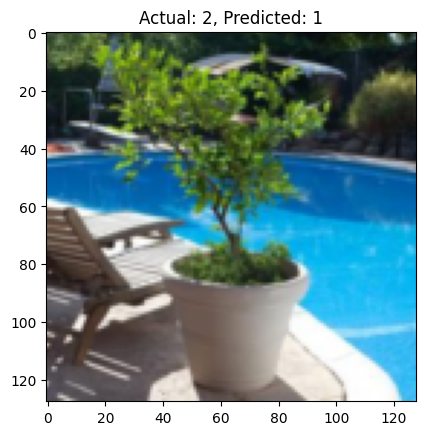

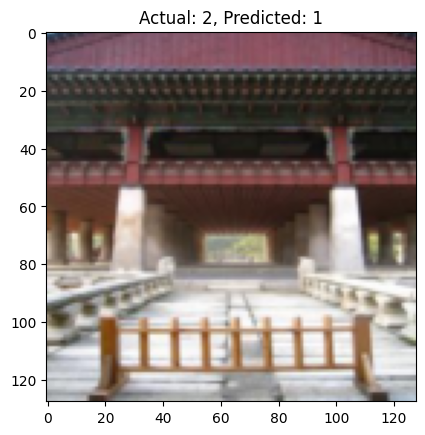

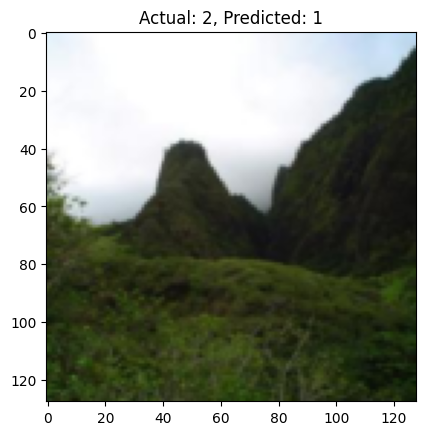

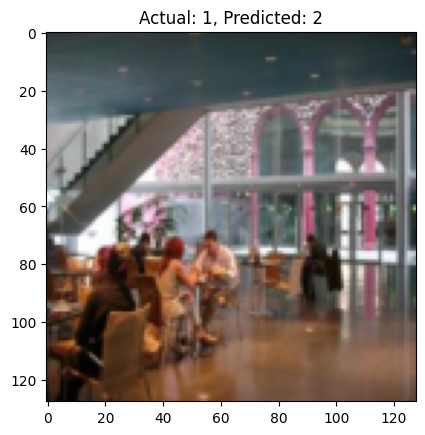

In [37]:
def imshow(img, title):
    """Функция для отображения изображения"""
    img = img / 2 + 0.5  # Деинвертируем нормализацию
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def inference_and_visualize_errors(model, test_loader):
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float().view(-1)

            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                incorrect_images.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].cpu().item())
                incorrect_preds.append(predicted[idx].cpu().item())

    for i in range(min(10, len(incorrect_images))):
        imshow(incorrect_images[i], f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

        writer.add_image(f'Error_{i}', incorrect_images[i])
        writer.add_text(f'Error_{i}', f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

inference_and_visualize_errors(model, test_loader)


# Домашнее задание

Обучить бинарный классификатор на основе сверточных нейронных сетей для датасета.
- Вы вольны выбирать любое количество слоёв, подбирать гиперпараметры, выбирать оптимизатор, функцию ошибки итд.    
- Можете разбивать на train-val-test исходя из того, как думаете, что будет лучше.

4 балла:
- Модель должна работоспособна, воспроизводима, код должен быть читаемым;
- Метрика качества accuracy должна быть не ниже 0.9;
- Процесс схождения должен быть залогирован (хотя бы просто графиками в matplotlib, но желательно втч. и в Tensorboard/ClearML/...).

5 баллов:
- Всё то же самое, что на 4 балла, но выполнены подзадания 1, 2 и 3, а метрика качества accuracy должна быть не ниже 0.95.



Подзадания:
1) Выведите кол-во обучаемых параметров сети;    
2) Напишите несколько предложений выводов - что помогло в решении и повысило качество, что нет.    
3) Посчитайте F1-score на тестовой подвыборке.

По желанию к выполнению, в разбалловке не учитывается:     
3) Выведите confusion matrix для тестовой подвыборки;    

In [83]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [84]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Используется устройство: {device}')

Используется устройство: cuda


In [87]:
# Конфигурация
class Config:
    data_dir = './PetImages/'
    num_epochs = 25
    batch_size = 32
    learning_rate = 1e-3
    num_classes = 1
    seed = 42
    validation_split = 0.2
    test_split = 0.1
    log_dir = 'runs/indoor_outdoor_classification'

In [88]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],   # Средние значения RGB каналов
                             [0.229, 0.224, 0.225])   # Стандартные отклонения RGB каналов
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


In [92]:
class CustomImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.classes = ['indoor', 'outdoor']  # Указываем только нужные классы
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.imgs = self.make_dataset()

    def make_dataset(self):
        instances = []
        for target_class in self.classes:
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(self.root, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in sorted(fnames):
                    if fname.startswith('._'):  # Игнорируем скрытые файлы
                        continue
                    path = os.path.join(root, fname)
                    if not path.endswith('.ipynb_checkpoints'):  # Игнорируем папку .ipynb_checkpoints
                        item = (path, class_index)
                        instances.append(item)
        return instances

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = Image.open(path).convert('RGB')  # Предполагаем, что изображения могут быть не только в формате jpg
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.imgs)

data_dir = './PetImages/'

full_dataset = CustomImageFolder(data_dir, transform=transform)

In [89]:
full_dataset = datasets.ImageFolder(root=Config.data_dir, transform=data_transforms['train'])

FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [93]:
total_size = len(full_dataset)
test_size = int(total_size * Config.test_split)
val_size = int(total_size * Config.validation_split)
train_size = total_size - val_size - test_size

In [94]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],
                                                       generator=torch.Generator().manual_seed(Config.seed))

In [95]:
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

In [96]:
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=4)

In [97]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}


In [98]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Первый блок
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Второй блок
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Третий блок
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Четвёртый блок
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Пятый блок
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x  # Используем BCEWithLogitsLoss, поэтому не применяем sigmoid здесь

In [111]:
# v2
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Первый блок
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Второй блок
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Третий блок
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Четвёртый блок
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Пятый блок
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Шестой блок
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Седьмой блок
            nn.Conv2d(1024, 2048, kernel_size=3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(2048 * 1 * 1, 1024), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) 
        x = self.fc_layers(x)
        return x  # Используем BCEWithLogitsLoss, поэтому не применяем sigmoid здесь

In [127]:
#v3
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Первый блок
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Второй блок (с Residual Connection)
            ResidualBlock(32, 64),
            nn.MaxPool2d(2),

            # Третий блок (с Residual Connection)
            ResidualBlock(64, 128),
            nn.MaxPool2d(2),

            # Четвёртый блок (с Residual Connection)
            ResidualBlock(128, 256),
            nn.MaxPool2d(2),

            # Пятый блок (с Residual Connection)
            ResidualBlock(256, 512),
            nn.MaxPool2d(2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x  # Используем BCEWithLogitsLoss, поэтому не применяем sigmoid здесь

In [138]:
#v4
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  #SE block
        out += identity
        out = self.relu(out)
        return out

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            ResidualBlock(32, 64),
            nn.MaxPool2d(2),

            ResidualBlock(64, 128),
            nn.MaxPool2d(2),

            ResidualBlock(128, 256),
            nn.MaxPool2d(2),

            ResidualBlock(256, 512),
            nn.MaxPool2d(2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x # Используем BCEWithLogitsLoss, поэтому не применяем sigmoid здесь

In [149]:
#v5
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # Apply SE block
        out += identity
        out = self.relu(out)
        return out

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=1):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            ResidualBlock(32, 64),
            nn.MaxPool2d(2),

            ResidualBlock(64, 128),
            nn.MaxPool2d(2),

            ResidualBlock(128, 256),
            nn.MaxPool2d(2),

            ResidualBlock(256, 512),
            nn.MaxPool2d(2),

            ResidualBlock(512, 1024),
            nn.MaxPool2d(2),

            ResidualBlock(1024, 2048),
            nn.AdaptiveAvgPool2d((1, 1))  
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x  # Используем BCEWithLogitsLoss, поэтому не применяем sigmoid здесь

In [150]:
model = ImprovedCNN(num_classes=Config.num_classes)
model = nn.DataParallel(model)
model = model.to(device)

In [151]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)

In [152]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [153]:
writer = SummaryWriter(Config.log_dir)

In [154]:
def save_checkpoint(state, filename='checkpoint_v5.pth'):
    torch.save(state, filename)

In [155]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = None
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase}'):
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)  # Для BCEWithLogitsLoss
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    preds = torch.sigmoid(outputs) > 0.5
                    corrects = torch.sum(preds == labels.byte())
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += corrects.item()
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Логирование в TensorBoard
            if phase == 'train':
                writer.add_scalar('Loss/train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/train', epoch_acc, epoch)
            else:
                writer.add_scalar('Loss/val', epoch_loss, epoch)
                writer.add_scalar('Accuracy/val', epoch_acc, epoch)
                
            # Сохранение лучшей модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                save_checkpoint({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'accuracy': epoch_acc
                }, 'best_model_v5.pth')
                print(f'Лучшая модель сохранена с точностью: {best_acc:.4f}')
        
        print()
    
    print(f'Лучшая валидационная точность: {best_acc:.4f}')
    
    # Загрузка лучших весов
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    return model, history

In [167]:
def evaluate_on_test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Test'):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            preds = torch.sigmoid(outputs) > 0.5
            corrects = torch.sum(preds == labels.byte())
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += corrects.item()
            total += labels.size(0)
    
    test_loss = running_loss / total
    test_acc = running_corrects / total
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    return test_loss, test_acc

In [106]:
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=Config.num_epochs)

Epoch 1/25
----------


train: 100%|██████████| 8981/8981 [04:44<00:00, 31.55it/s]


train Loss: 0.3629 Acc: 0.8527


val: 100%|██████████| 2566/2566 [00:55<00:00, 46.09it/s]


val Loss: 0.2807 Acc: 0.8881
Лучшая модель сохранена с точностью: 0.8881

Epoch 2/25
----------


train: 100%|██████████| 8981/8981 [04:46<00:00, 31.39it/s]


train Loss: 0.2715 Acc: 0.8947


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.26it/s]


val Loss: 0.2450 Acc: 0.9029
Лучшая модель сохранена с точностью: 0.9029

Epoch 3/25
----------


train: 100%|██████████| 8981/8981 [04:46<00:00, 31.33it/s]


train Loss: 0.2411 Acc: 0.9078


val: 100%|██████████| 2566/2566 [00:55<00:00, 46.32it/s]


val Loss: 0.2248 Acc: 0.9130
Лучшая модель сохранена с точностью: 0.9130

Epoch 4/25
----------


train: 100%|██████████| 8981/8981 [04:43<00:00, 31.70it/s]


train Loss: 0.2211 Acc: 0.9156


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.39it/s]


val Loss: 0.2109 Acc: 0.9182
Лучшая модель сохранена с точностью: 0.9182

Epoch 5/25
----------


train: 100%|██████████| 8981/8981 [04:43<00:00, 31.69it/s]


train Loss: 0.2055 Acc: 0.9221


val: 100%|██████████| 2566/2566 [00:53<00:00, 47.55it/s]


val Loss: 0.2159 Acc: 0.9182

Epoch 6/25
----------


train: 100%|██████████| 8981/8981 [04:42<00:00, 31.79it/s]


train Loss: 0.1910 Acc: 0.9279


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.45it/s]


val Loss: 0.2056 Acc: 0.9220
Лучшая модель сохранена с точностью: 0.9220

Epoch 7/25
----------


train: 100%|██████████| 8981/8981 [04:42<00:00, 31.74it/s]


train Loss: 0.1754 Acc: 0.9331


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.36it/s]


val Loss: 0.2142 Acc: 0.9247
Лучшая модель сохранена с точностью: 0.9247

Epoch 8/25
----------


train: 100%|██████████| 8981/8981 [04:42<00:00, 31.83it/s]


train Loss: 0.1283 Acc: 0.9513


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.49it/s]


val Loss: 0.2084 Acc: 0.9284
Лучшая модель сохранена с точностью: 0.9284

Epoch 9/25
----------


train: 100%|██████████| 8981/8981 [04:43<00:00, 31.68it/s]


train Loss: 0.1145 Acc: 0.9569


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.24it/s]


val Loss: 0.2197 Acc: 0.9282

Epoch 10/25
----------


train: 100%|██████████| 8981/8981 [04:42<00:00, 31.82it/s]


train Loss: 0.1057 Acc: 0.9593


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.20it/s]


val Loss: 0.2352 Acc: 0.9260

Epoch 11/25
----------


train: 100%|██████████| 8981/8981 [04:45<00:00, 31.48it/s]


train Loss: 0.0979 Acc: 0.9623


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.21it/s]


val Loss: 0.2404 Acc: 0.9236

Epoch 12/25
----------


train: 100%|██████████| 8981/8981 [04:42<00:00, 31.81it/s]


train Loss: 0.0905 Acc: 0.9651


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.45it/s]


val Loss: 0.2591 Acc: 0.9249

Epoch 13/25
----------


train: 100%|██████████| 8981/8981 [04:44<00:00, 31.57it/s]


train Loss: 0.0832 Acc: 0.9674


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.14it/s]


val Loss: 0.2934 Acc: 0.9225

Epoch 14/25
----------


train: 100%|██████████| 8981/8981 [04:49<00:00, 31.03it/s]


train Loss: 0.0769 Acc: 0.9702


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.33it/s]


val Loss: 0.3096 Acc: 0.9229

Epoch 15/25
----------


train: 100%|██████████| 8981/8981 [04:42<00:00, 31.81it/s]


train Loss: 0.0673 Acc: 0.9738


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.39it/s]


val Loss: 0.2945 Acc: 0.9247

Epoch 16/25
----------


train: 100%|██████████| 8981/8981 [04:44<00:00, 31.61it/s]


train Loss: 0.0655 Acc: 0.9743


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.34it/s]


val Loss: 0.3107 Acc: 0.9242

Epoch 17/25
----------


train: 100%|██████████| 8981/8981 [04:41<00:00, 31.91it/s]


train Loss: 0.0648 Acc: 0.9751


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.44it/s]


val Loss: 0.3095 Acc: 0.9244

Epoch 18/25
----------


train: 100%|██████████| 8981/8981 [04:43<00:00, 31.72it/s]


train Loss: 0.0637 Acc: 0.9751


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.34it/s]


val Loss: 0.3156 Acc: 0.9243

Epoch 19/25
----------


train: 100%|██████████| 8981/8981 [04:44<00:00, 31.58it/s]


train Loss: 0.0626 Acc: 0.9754


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.30it/s]


val Loss: 0.3057 Acc: 0.9233

Epoch 20/25
----------


train: 100%|██████████| 8981/8981 [04:41<00:00, 31.87it/s]


train Loss: 0.0621 Acc: 0.9761


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.28it/s]


val Loss: 0.3260 Acc: 0.9254

Epoch 21/25
----------


train: 100%|██████████| 8981/8981 [04:43<00:00, 31.73it/s]


train Loss: 0.0612 Acc: 0.9763


val: 100%|██████████| 2566/2566 [00:53<00:00, 47.61it/s]


val Loss: 0.3214 Acc: 0.9234

Epoch 22/25
----------


train: 100%|██████████| 8981/8981 [04:42<00:00, 31.83it/s]


train Loss: 0.0600 Acc: 0.9766


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.50it/s]


val Loss: 0.3327 Acc: 0.9240

Epoch 23/25
----------


train: 100%|██████████| 8981/8981 [04:43<00:00, 31.66it/s]


train Loss: 0.0597 Acc: 0.9768


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.19it/s]


val Loss: 0.3316 Acc: 0.9233

Epoch 24/25
----------


train: 100%|██████████| 8981/8981 [04:44<00:00, 31.51it/s]


train Loss: 0.0604 Acc: 0.9765


val: 100%|██████████| 2566/2566 [00:53<00:00, 47.64it/s]


val Loss: 0.3242 Acc: 0.9236

Epoch 25/25
----------


train: 100%|██████████| 8981/8981 [04:43<00:00, 31.70it/s]


train Loss: 0.0591 Acc: 0.9770


val: 100%|██████████| 2566/2566 [00:54<00:00, 47.03it/s]

val Loss: 0.3227 Acc: 0.9239

Лучшая валидационная точность: 0.9284


In [107]:
test_loss, test_acc = evaluate_on_test(model, test_loader, criterion)

Test: 100%|██████████| 1283/1283 [00:27<00:00, 46.51it/s]

Test Loss: 0.3215 Acc: 0.9254


In [121]:
#v2
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=Config.num_epochs)

Epoch 1/25
----------


train: 100%|██████████| 8981/8981 [05:56<00:00, 25.23it/s]


train Loss: 0.3605 Acc: 0.8508


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.91it/s]


val Loss: 0.2642 Acc: 0.8937
Лучшая модель сохранена с точностью: 0.8937

Epoch 2/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.38it/s]


train Loss: 0.2728 Acc: 0.8938


val: 100%|██████████| 2566/2566 [01:03<00:00, 40.11it/s]


val Loss: 0.2588 Acc: 0.9012
Лучшая модель сохранена с точностью: 0.9012

Epoch 3/25
----------


train: 100%|██████████| 8981/8981 [05:54<00:00, 25.33it/s]


train Loss: 0.2381 Acc: 0.9086


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.84it/s]


val Loss: 0.2240 Acc: 0.9145
Лучшая модель сохранена с точностью: 0.9145

Epoch 4/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.42it/s]


train Loss: 0.2156 Acc: 0.9177


val: 100%|██████████| 2566/2566 [01:04<00:00, 40.03it/s]


val Loss: 0.2363 Acc: 0.9059

Epoch 5/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.44it/s]


train Loss: 0.1983 Acc: 0.9249


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.95it/s]


val Loss: 0.2078 Acc: 0.9219
Лучшая модель сохранена с точностью: 0.9219

Epoch 6/25
----------


train: 100%|██████████| 8981/8981 [05:54<00:00, 25.32it/s]


train Loss: 0.1802 Acc: 0.9319


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.80it/s]


val Loss: 0.1912 Acc: 0.9269
Лучшая модель сохранена с точностью: 0.9269

Epoch 7/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.40it/s]


train Loss: 0.1623 Acc: 0.9394


val: 100%|██████████| 2566/2566 [01:04<00:00, 40.02it/s]


val Loss: 0.1920 Acc: 0.9273
Лучшая модель сохранена с точностью: 0.9273

Epoch 8/25
----------


train: 100%|██████████| 8981/8981 [05:52<00:00, 25.46it/s]


train Loss: 0.1065 Acc: 0.9619


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.91it/s]


val Loss: 0.1924 Acc: 0.9299
Лучшая модель сохранена с точностью: 0.9299

Epoch 9/25
----------


train: 100%|██████████| 8981/8981 [05:52<00:00, 25.44it/s]


train Loss: 0.0889 Acc: 0.9688


val: 100%|██████████| 2566/2566 [01:03<00:00, 40.20it/s]


val Loss: 0.2063 Acc: 0.9293

Epoch 10/25
----------


train: 100%|██████████| 8981/8981 [05:54<00:00, 25.35it/s]


train Loss: 0.0766 Acc: 0.9733


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.73it/s]


val Loss: 0.2163 Acc: 0.9263

Epoch 11/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.37it/s]


train Loss: 0.0669 Acc: 0.9770


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.88it/s]


val Loss: 0.2227 Acc: 0.9261

Epoch 12/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.44it/s]


train Loss: 0.0582 Acc: 0.9800


val: 100%|██████████| 2566/2566 [01:04<00:00, 40.01it/s]


val Loss: 0.2447 Acc: 0.9238

Epoch 13/25
----------


train: 100%|██████████| 8981/8981 [05:54<00:00, 25.32it/s]


train Loss: 0.0504 Acc: 0.9829


val: 100%|██████████| 2566/2566 [01:03<00:00, 40.14it/s]


val Loss: 0.2770 Acc: 0.9209

Epoch 14/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.38it/s]


train Loss: 0.0426 Acc: 0.9857


val: 100%|██████████| 2566/2566 [01:04<00:00, 40.07it/s]


val Loss: 0.2788 Acc: 0.9230

Epoch 15/25
----------


train: 100%|██████████| 8981/8981 [05:54<00:00, 25.31it/s]


train Loss: 0.0328 Acc: 0.9892


val: 100%|██████████| 2566/2566 [01:03<00:00, 40.12it/s]


val Loss: 0.2894 Acc: 0.9214

Epoch 16/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.42it/s]


train Loss: 0.0314 Acc: 0.9897


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.98it/s]


val Loss: 0.2971 Acc: 0.9208

Epoch 17/25
----------


train: 100%|██████████| 8981/8981 [05:52<00:00, 25.44it/s]


train Loss: 0.0299 Acc: 0.9902


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.84it/s]


val Loss: 0.3086 Acc: 0.9208

Epoch 18/25
----------


train: 100%|██████████| 8981/8981 [05:55<00:00, 25.26it/s]


train Loss: 0.0285 Acc: 0.9905


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.81it/s]


val Loss: 0.3120 Acc: 0.9221

Epoch 19/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.42it/s]


train Loss: 0.0278 Acc: 0.9908


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.93it/s]


val Loss: 0.3078 Acc: 0.9221

Epoch 20/25
----------


train: 100%|██████████| 8981/8981 [05:53<00:00, 25.38it/s]


train Loss: 0.0273 Acc: 0.9911


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.95it/s]


val Loss: 0.3184 Acc: 0.9214

Epoch 21/25
----------


train: 100%|██████████| 8981/8981 [05:51<00:00, 25.54it/s]


train Loss: 0.0265 Acc: 0.9912


val: 100%|██████████| 2566/2566 [01:04<00:00, 40.04it/s]


val Loss: 0.3144 Acc: 0.9213

Epoch 22/25
----------


train: 100%|██████████| 8981/8981 [05:49<00:00, 25.70it/s]


train Loss: 0.0259 Acc: 0.9917


val: 100%|██████████| 2566/2566 [01:04<00:00, 39.93it/s]


val Loss: 0.3199 Acc: 0.9215

Epoch 23/25
----------


train: 100%|██████████| 8981/8981 [05:54<00:00, 25.30it/s]


train Loss: 0.0259 Acc: 0.9915


val: 100%|██████████| 2566/2566 [01:05<00:00, 39.23it/s]


val Loss: 0.3194 Acc: 0.9208

Epoch 24/25
----------


train: 100%|██████████| 8981/8981 [05:59<00:00, 25.01it/s]


train Loss: 0.0255 Acc: 0.9915


val: 100%|██████████| 2566/2566 [01:05<00:00, 39.24it/s]


val Loss: 0.3242 Acc: 0.9209

Epoch 25/25
----------


train: 100%|██████████| 8981/8981 [05:58<00:00, 25.07it/s]


train Loss: 0.0249 Acc: 0.9918


val: 100%|██████████| 2566/2566 [01:03<00:00, 40.17it/s]

val Loss: 0.3246 Acc: 0.9222

Лучшая валидационная точность: 0.9299


In [122]:
#v2
test_loss, test_acc = evaluate_on_test(model, test_loader, criterion)

Test: 100%|██████████| 1283/1283 [00:32<00:00, 39.42it/s]

Test Loss: 0.3222 Acc: 0.9231


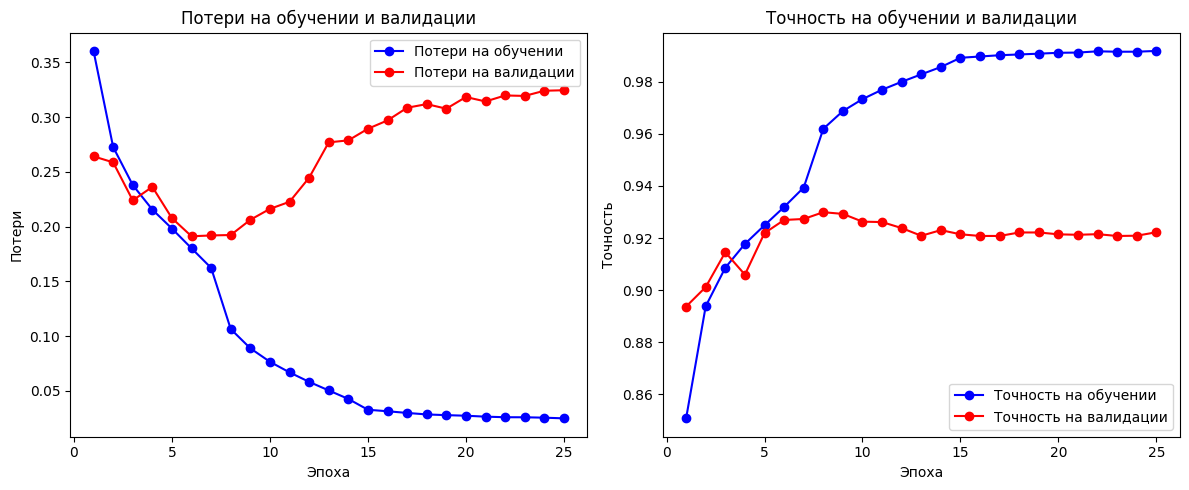

In [123]:
#v2
plot_history(history)

In [135]:
#v3
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=16)

Epoch 1/16
----------


train: 100%|██████████| 8981/8981 [08:27<00:00, 17.69it/s]


train Loss: 0.3406 Acc: 0.8603


val: 100%|██████████| 2566/2566 [01:27<00:00, 29.22it/s]


val Loss: 0.2553 Acc: 0.9005
Лучшая модель сохранена с точностью: 0.9005

Epoch 2/16
----------


train: 100%|██████████| 8981/8981 [08:30<00:00, 17.59it/s]


train Loss: 0.2587 Acc: 0.8996


val: 100%|██████████| 2566/2566 [01:29<00:00, 28.78it/s]


val Loss: 0.2731 Acc: 0.8921

Epoch 3/16
----------


train: 100%|██████████| 8981/8981 [08:33<00:00, 17.48it/s]


train Loss: 0.2326 Acc: 0.9114


val: 100%|██████████| 2566/2566 [01:27<00:00, 29.47it/s]


val Loss: 0.2837 Acc: 0.8919

Epoch 4/16
----------


train: 100%|██████████| 8981/8981 [08:28<00:00, 17.66it/s]


train Loss: 0.2170 Acc: 0.9183


val: 100%|██████████| 2566/2566 [01:29<00:00, 28.77it/s]


val Loss: 0.2411 Acc: 0.9188
Лучшая модель сохранена с точностью: 0.9188

Epoch 5/16
----------


train: 100%|██████████| 8981/8981 [08:28<00:00, 17.67it/s]


train Loss: 0.2029 Acc: 0.9235


val: 100%|██████████| 2566/2566 [01:27<00:00, 29.21it/s]


val Loss: 0.2531 Acc: 0.9202
Лучшая модель сохранена с точностью: 0.9202

Epoch 6/16
----------


train: 100%|██████████| 8981/8981 [08:27<00:00, 17.69it/s]


train Loss: 0.1917 Acc: 0.9283


val: 100%|██████████| 2566/2566 [01:27<00:00, 29.16it/s]


val Loss: 0.2107 Acc: 0.9219
Лучшая модель сохранена с точностью: 0.9219

Epoch 7/16
----------


train: 100%|██████████| 8981/8981 [08:39<00:00, 17.29it/s]


train Loss: 0.1822 Acc: 0.9318


val: 100%|██████████| 2566/2566 [01:25<00:00, 29.88it/s]


val Loss: 0.2529 Acc: 0.9227
Лучшая модель сохранена с точностью: 0.9227

Epoch 8/16
----------


train: 100%|██████████| 8981/8981 [08:25<00:00, 17.78it/s]


train Loss: 0.1488 Acc: 0.9453


val: 100%|██████████| 2566/2566 [01:26<00:00, 29.68it/s]


val Loss: 0.2554 Acc: 0.9322
Лучшая модель сохранена с точностью: 0.9322

Epoch 9/16
----------


train: 100%|██████████| 8981/8981 [08:27<00:00, 17.71it/s]


train Loss: 0.1380 Acc: 0.9492


val: 100%|██████████| 2566/2566 [01:26<00:00, 29.57it/s]


val Loss: 0.2156 Acc: 0.9340
Лучшая модель сохранена с точностью: 0.9340

Epoch 10/16
----------


train: 100%|██████████| 8981/8981 [08:45<00:00, 17.08it/s]


train Loss: 0.1328 Acc: 0.9512


val: 100%|██████████| 2566/2566 [01:29<00:00, 28.65it/s]


val Loss: 0.2579 Acc: 0.9321

Epoch 11/16
----------


train: 100%|██████████| 8981/8981 [08:42<00:00, 17.19it/s]


train Loss: 0.1275 Acc: 0.9528


val: 100%|██████████| 2566/2566 [01:29<00:00, 28.71it/s]


val Loss: 0.2511 Acc: 0.9335

Epoch 12/16
----------


train: 100%|██████████| 8981/8981 [08:27<00:00, 17.70it/s]


train Loss: 0.1236 Acc: 0.9540


val: 100%|██████████| 2566/2566 [01:27<00:00, 29.43it/s]


val Loss: 0.2337 Acc: 0.9347
Лучшая модель сохранена с точностью: 0.9347

Epoch 13/16
----------


train: 100%|██████████| 8981/8981 [08:37<00:00, 17.37it/s]


train Loss: 0.1186 Acc: 0.9556


val: 100%|██████████| 2566/2566 [01:28<00:00, 29.06it/s]


val Loss: 0.2422 Acc: 0.9339

Epoch 14/16
----------


train: 100%|██████████| 8981/8981 [08:35<00:00, 17.44it/s]


train Loss: 0.1147 Acc: 0.9573


val: 100%|██████████| 2566/2566 [01:27<00:00, 29.18it/s]


val Loss: 0.2319 Acc: 0.9321

Epoch 15/16
----------


train: 100%|██████████| 8981/8981 [08:39<00:00, 17.30it/s]


train Loss: 0.1066 Acc: 0.9600


val: 100%|██████████| 2566/2566 [01:28<00:00, 28.88it/s]


val Loss: 0.2951 Acc: 0.9325

Epoch 16/16
----------


train: 100%|██████████| 8981/8981 [08:30<00:00, 17.61it/s]


train Loss: 0.1058 Acc: 0.9604


val: 100%|██████████| 2566/2566 [01:26<00:00, 29.58it/s]

val Loss: 0.2858 Acc: 0.9324

Лучшая валидационная точность: 0.9347


In [136]:
#v3
test_loss, test_acc = evaluate_on_test(model, test_loader, criterion)

Test: 100%|██████████| 1283/1283 [00:43<00:00, 29.63it/s]

Test Loss: 0.2806 Acc: 0.9333


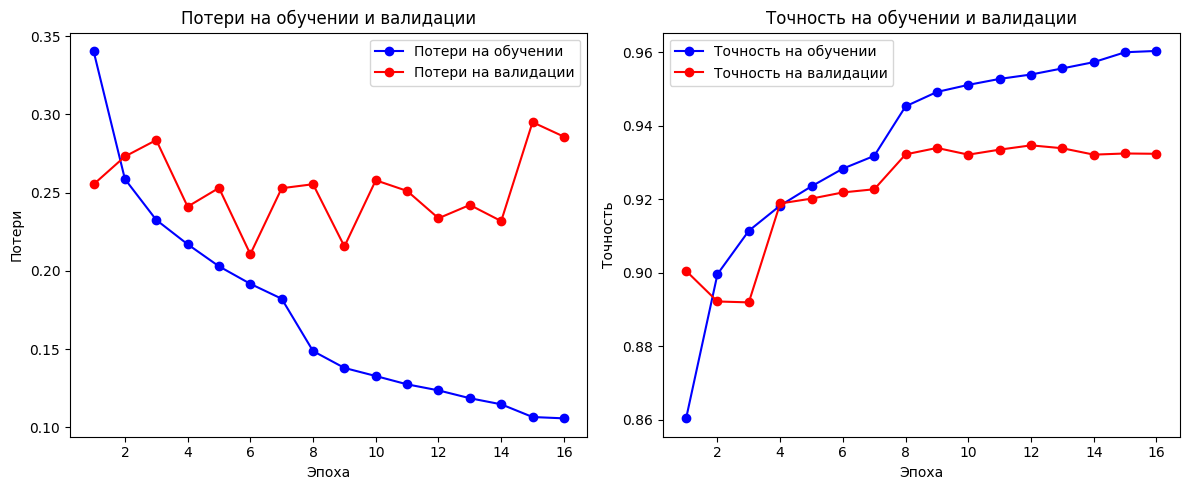

In [137]:
#v3
plot_history(history)

In [146]:
#v4
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=16)

Epoch 1/16
----------


train: 100%|██████████| 8981/8981 [10:28<00:00, 14.29it/s]


train Loss: 0.3347 Acc: 0.8645


val: 100%|██████████| 2566/2566 [01:55<00:00, 22.28it/s]


val Loss: 0.2553 Acc: 0.8982
Лучшая модель сохранена с точностью: 0.8982

Epoch 2/16
----------


train: 100%|██████████| 8981/8981 [10:18<00:00, 14.52it/s]


train Loss: 0.2566 Acc: 0.9011


val: 100%|██████████| 2566/2566 [01:55<00:00, 22.29it/s]


val Loss: 0.2500 Acc: 0.9035
Лучшая модель сохранена с точностью: 0.9035

Epoch 3/16
----------


train: 100%|██████████| 8981/8981 [10:20<00:00, 14.48it/s]


train Loss: 0.2305 Acc: 0.9124


val: 100%|██████████| 2566/2566 [01:54<00:00, 22.39it/s]


val Loss: 0.2131 Acc: 0.9187
Лучшая модель сохранена с точностью: 0.9187

Epoch 4/16
----------


train: 100%|██████████| 8981/8981 [10:20<00:00, 14.47it/s]


train Loss: 0.2119 Acc: 0.9203


val: 100%|██████████| 2566/2566 [01:54<00:00, 22.33it/s]


val Loss: 0.2050 Acc: 0.9228
Лучшая модель сохранена с точностью: 0.9228

Epoch 5/16
----------


train: 100%|██████████| 8981/8981 [10:20<00:00, 14.48it/s]


train Loss: 0.1999 Acc: 0.9253


val: 100%|██████████| 2566/2566 [01:54<00:00, 22.34it/s]


val Loss: 0.2051 Acc: 0.9240
Лучшая модель сохранена с точностью: 0.9240

Epoch 6/16
----------


train: 100%|██████████| 8981/8981 [10:22<00:00, 14.42it/s]


train Loss: 0.1870 Acc: 0.9304


val: 100%|██████████| 2566/2566 [01:55<00:00, 22.27it/s]


val Loss: 0.2130 Acc: 0.9226

Epoch 7/16
----------


train: 100%|██████████| 8981/8981 [10:19<00:00, 14.50it/s]


train Loss: 0.1778 Acc: 0.9342


val: 100%|██████████| 2566/2566 [01:57<00:00, 21.78it/s]


val Loss: 0.2108 Acc: 0.9219

Epoch 8/16
----------


train: 100%|██████████| 8981/8981 [10:18<00:00, 14.51it/s]


train Loss: 0.1417 Acc: 0.9475


val: 100%|██████████| 2566/2566 [01:52<00:00, 22.80it/s]


val Loss: 0.1755 Acc: 0.9361
Лучшая модель сохранена с точностью: 0.9361

Epoch 9/16
----------


train: 100%|██████████| 8981/8981 [10:18<00:00, 14.53it/s]


train Loss: 0.1314 Acc: 0.9511


val: 100%|██████████| 2566/2566 [02:01<00:00, 21.12it/s]


val Loss: 0.1779 Acc: 0.9353

Epoch 10/16
----------


train: 100%|██████████| 8981/8981 [10:17<00:00, 14.55it/s]


train Loss: 0.1254 Acc: 0.9532


val: 100%|██████████| 2566/2566 [01:58<00:00, 21.68it/s]


val Loss: 0.1812 Acc: 0.9370
Лучшая модель сохранена с точностью: 0.9370

Epoch 11/16
----------


train: 100%|██████████| 8981/8981 [10:21<00:00, 14.45it/s]


train Loss: 0.1205 Acc: 0.9551


val: 100%|██████████| 2566/2566 [01:59<00:00, 21.49it/s]


val Loss: 0.1878 Acc: 0.9337

Epoch 12/16
----------


train: 100%|██████████| 8981/8981 [10:17<00:00, 14.53it/s]


train Loss: 0.1151 Acc: 0.9568


val: 100%|██████████| 2566/2566 [01:53<00:00, 22.70it/s]


val Loss: 0.1938 Acc: 0.9340

Epoch 13/16
----------


train: 100%|██████████| 8981/8981 [10:16<00:00, 14.56it/s]


train Loss: 0.1100 Acc: 0.9586


val: 100%|██████████| 2566/2566 [01:57<00:00, 21.82it/s]


val Loss: 0.1906 Acc: 0.9347

Epoch 14/16
----------


train: 100%|██████████| 8981/8981 [10:18<00:00, 14.52it/s]


train Loss: 0.1053 Acc: 0.9601


val: 100%|██████████| 2566/2566 [01:53<00:00, 22.65it/s]


val Loss: 0.2026 Acc: 0.9331

Epoch 15/16
----------


train: 100%|██████████| 8981/8981 [10:24<00:00, 14.38it/s]


train Loss: 0.0975 Acc: 0.9634


val: 100%|██████████| 2566/2566 [01:59<00:00, 21.46it/s]


val Loss: 0.2009 Acc: 0.9350

Epoch 16/16
----------


train: 100%|██████████| 8981/8981 [10:29<00:00, 14.27it/s]


train Loss: 0.0950 Acc: 0.9642


val: 100%|██████████| 2566/2566 [01:52<00:00, 22.76it/s]

val Loss: 0.2011 Acc: 0.9358

Лучшая валидационная точность: 0.9370


In [147]:
#v4
test_loss, test_acc = evaluate_on_test(model, test_loader, criterion)

Test: 100%|██████████| 1283/1283 [01:01<00:00, 20.74it/s]

Test Loss: 0.1957 Acc: 0.9365


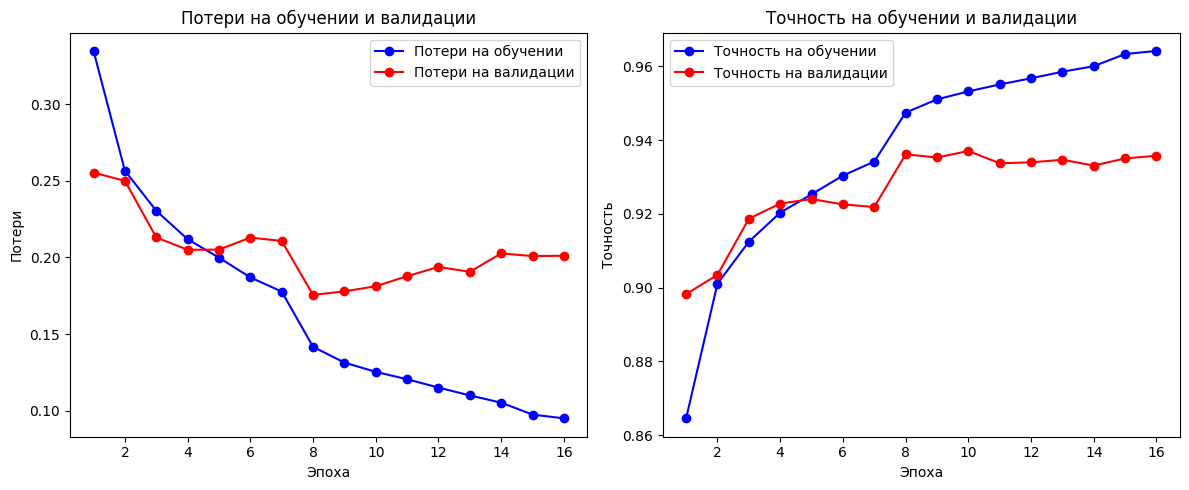

In [148]:
#v4
plot_history(history)

In [ ]:
#v5
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------


train: 100%|██████████| 8981/8981 [15:25<00:00,  9.70it/s]


train Loss: 0.3306 Acc: 0.8659


val: 100%|██████████| 2566/2566 [02:47<00:00, 15.31it/s]


val Loss: 0.2828 Acc: 0.9012
Лучшая модель сохранена с точностью: 0.9012

Epoch 2/25
----------


train: 100%|██████████| 8981/8981 [15:20<00:00,  9.75it/s]


train Loss: 0.2528 Acc: 0.9030


val: 100%|██████████| 2566/2566 [02:50<00:00, 15.08it/s]


val Loss: 0.2464 Acc: 0.9146
Лучшая модель сохранена с точностью: 0.9146

Epoch 3/25
----------


train: 100%|██████████| 8981/8981 [15:41<00:00,  9.54it/s]


train Loss: 0.2265 Acc: 0.9135


val: 100%|██████████| 2566/2566 [02:46<00:00, 15.41it/s]


val Loss: 0.2405 Acc: 0.9184
Лучшая модель сохранена с точностью: 0.9184

Epoch 4/25
----------


train: 100%|██████████| 8981/8981 [15:22<00:00,  9.73it/s]


train Loss: 0.2099 Acc: 0.9209


val: 100%|██████████| 2566/2566 [02:45<00:00, 15.49it/s]


val Loss: 0.2578 Acc: 0.9135

Epoch 5/25
----------


train: 100%|██████████| 8981/8981 [15:23<00:00,  9.73it/s]


train Loss: 0.1969 Acc: 0.9265


val: 100%|██████████| 2566/2566 [02:48<00:00, 15.27it/s]


val Loss: 0.2594 Acc: 0.9235
Лучшая модель сохранена с точностью: 0.9235

Epoch 6/25
----------


train: 100%|██████████| 8981/8981 [15:34<00:00,  9.62it/s]


train Loss: 0.1852 Acc: 0.9314


val: 100%|██████████| 2566/2566 [02:51<00:00, 14.96it/s]


val Loss: 0.2610 Acc: 0.9251
Лучшая модель сохранена с точностью: 0.9251

Epoch 7/25
----------


train: 100%|██████████| 8981/8981 [15:29<00:00,  9.66it/s]


train Loss: 0.1748 Acc: 0.9355


val: 100%|██████████| 2566/2566 [02:49<00:00, 15.10it/s]


val Loss: 0.2352 Acc: 0.9293
Лучшая модель сохранена с точностью: 0.9293

Epoch 8/25
----------


train: 100%|██████████| 8981/8981 [15:22<00:00,  9.73it/s]


train Loss: 0.1412 Acc: 0.9484


val: 100%|██████████| 2566/2566 [02:44<00:00, 15.64it/s]


val Loss: 0.1920 Acc: 0.9369
Лучшая модель сохранена с точностью: 0.9369

Epoch 9/25
----------


train: 100%|██████████| 8981/8981 [15:20<00:00,  9.76it/s]


train Loss: 0.1316 Acc: 0.9519


val: 100%|██████████| 2566/2566 [02:43<00:00, 15.67it/s]


val Loss: 0.1957 Acc: 0.9370
Лучшая модель сохранена с точностью: 0.9370

Epoch 10/25
----------


train: 100%|██████████| 8981/8981 [15:22<00:00,  9.74it/s]


train Loss: 0.1249 Acc: 0.9545


val: 100%|██████████| 2566/2566 [02:43<00:00, 15.72it/s]


val Loss: 0.1912 Acc: 0.9377
Лучшая модель сохранена с точностью: 0.9377

Epoch 11/25
----------


train:  51%|█████▏    | 4611/8981 [07:53<07:00, 10.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
#v5
test_loss, test_acc = evaluate_on_test(model, test_loader, criterion)

In [ ]:
#v5
plot_history(history)

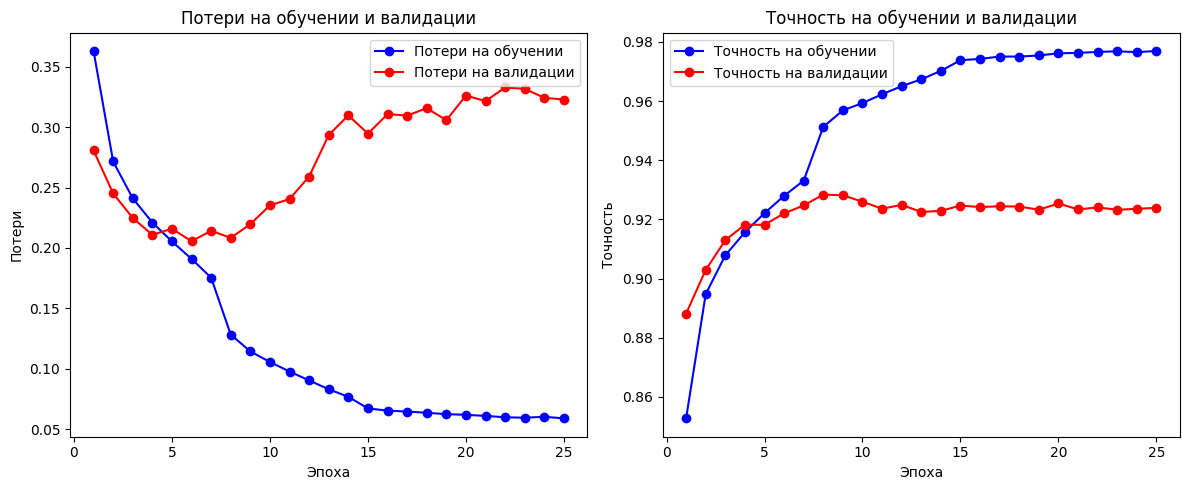

In [108]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12,5))
    
    # Потери
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Потери на обучении')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Потери на валидации')
    plt.title('Потери на обучении и валидации')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    
    # Точности
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Точность на обучении')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Точность на валидации')
    plt.title('Точность на обучении и валидации')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [124]:
writer.close()

In [125]:
torch.save(model.state_dict(), 'ImprovedCNN_v2.pth')

In [ ]:
#tensorboard --logdir=runs

In [164]:
def count_trainable_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

##  кол-во обучаемых параметров сети

In [165]:
count_trainable_params(model)

81634177

##  F1-score на тестовой подвыборке

In [173]:
from sklearn.metrics import f1_score

def evaluate_on_test_f1(model, test_loader):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Test'):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(inputs)
            
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            labels = labels.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    f1 = f1_score(all_labels, all_preds)
    
    print(f'F1-score: {f1:.4f}')
    
    return f1

In [176]:
test_f1 = evaluate_on_test_f1(model, test_loader)

Test: 100%|██████████| 1283/1283 [01:23<00:00, 15.34it/s]

F1-score: 0.9287


## confusion matrix для тестовой подвыборки;

In [177]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_on_test_with_confusion_matrix(model, test_loader):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Test'):
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(inputs)
            
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            labels = labels.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm

Test: 100%|██████████| 1283/1283 [01:25<00:00, 14.99it/s]


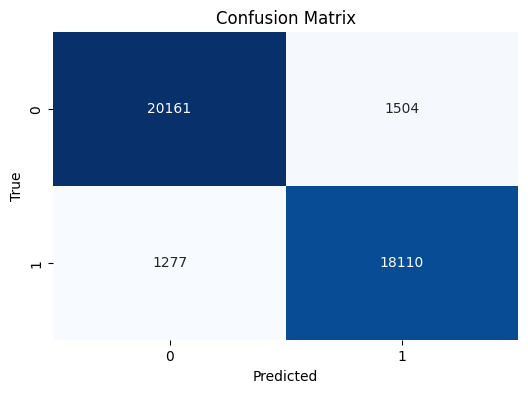

array([[20161,  1504],
       [ 1277, 18110]])

In [178]:
evaluate_on_test_with_confusion_matrix(model, test_loader)

## вывод

- Увеличение количества эпох и модулей иногда помогает, при черезмерном увеличении наоборот мешает
- Предобраобтка данных также влияет положительно
- Остаточные связи (ResidualBlock), как в ResNet, помогают
- Механизмы внимания (SEBlock) также помогают

вышеупомянутые методы повышают скор, но увеличивают время обучения

